In [1]:
# Import relevant packages
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import chain
import time
import seaborn as sns
import random
import math

### Read predictions

In [2]:
# Choose predictions
import os
os.chdir('/mnt/guanabana/raid/home/slomp006')

# Read dense prediction
# dense_pred = pd.read_csv("Output/RF/Dense/DenseRFPredict.csv") # dense RF
dense_pred = pd.read_csv("Output/LSTM/Dense/LSTM_dense.csv") # dense LSTM

# LSTM pred does not have a date column, so to be sure make new date column (just 1 to 92) for every prediction
dense_pred['date'] = dense_pred.groupby('location_id').cumcount() + 1

In [4]:
# Harmonise prediction

# Drop NA
dense_pred = dense_pred.dropna()

# Dense pred may not be a multiple of 92 now, remove incomplete samples
grouped = dense_pred.groupby('location_id')
dense_pred = grouped.filter(lambda x: len(x) == 92)
dense_pred = dense_pred.sort_values(by=['location_id', 'date'])

fractions_dict = {}
classes = ['tree', 'shrub', 'grassland', 'crops', 
           'urban_built_up', 'bare', 'water']
ids = ['location_id', 'x', 'y', 'date']
dates = dense_pred.date.unique()

for date in dates:
    # Loop through dates and make data frame for each date
    date_df = dense_pred.loc[dense_pred['date'] == date]
    date_df = date_df.sort_values(by=['location_id'])
    
    # Only use class columns
    date_df = date_df[classes]
    
    # Append to dictionary
    df_name = date 
    df_name = "pred"+str(df_name)
    fractions_dict.update({df_name: date_df})
    
print(len(fractions_dict), "data frames stored in dictionary:")
print(list(fractions_dict.keys()))

92 data frames stored in dictionary:
['pred1', 'pred2', 'pred3', 'pred4', 'pred5', 'pred6', 'pred7', 'pred8', 'pred9', 'pred10', 'pred11', 'pred12', 'pred13', 'pred14', 'pred15', 'pred16', 'pred17', 'pred18', 'pred19', 'pred20', 'pred21', 'pred22', 'pred23', 'pred24', 'pred25', 'pred26', 'pred27', 'pred28', 'pred29', 'pred30', 'pred31', 'pred32', 'pred33', 'pred34', 'pred35', 'pred36', 'pred37', 'pred38', 'pred39', 'pred40', 'pred41', 'pred42', 'pred43', 'pred44', 'pred45', 'pred46', 'pred47', 'pred48', 'pred49', 'pred50', 'pred51', 'pred52', 'pred53', 'pred54', 'pred55', 'pred56', 'pred57', 'pred58', 'pred59', 'pred60', 'pred61', 'pred62', 'pred63', 'pred64', 'pred65', 'pred66', 'pred67', 'pred68', 'pred69', 'pred70', 'pred71', 'pred72', 'pred73', 'pred74', 'pred75', 'pred76', 'pred77', 'pred78', 'pred79', 'pred80', 'pred81', 'pred82', 'pred83', 'pred84', 'pred85', 'pred86', 'pred87', 'pred88', 'pred89', 'pred90', 'pred91', 'pred92']


In [5]:
# The numbers refer to the dates. 1 is first date in January, 92 is last date in December

print(fractions_dict['pred1'].shape, fractions_dict['pred23'].shape, 
      fractions_dict['pred46'].shape, fractions_dict['pred90'].shape)

(30674, 7) (30674, 7) (30674, 7) (30674, 7)


### Read training 

In [6]:
traindf = pd.read_csv("Input/Change/train20152018.csv")

df2015 = traindf.loc[traindf['reference_year'] == 2015]
df2016 = traindf.loc[traindf['reference_year'] == 2016]
df2017 = traindf.loc[traindf['reference_year'] == 2017]
df2018 = traindf.loc[traindf['reference_year'] == 2018]

# Again, only use class columns
df2015 = df2015[df2015.columns.intersection(classes)]
df2016 = df2016[df2015.columns.intersection(classes)]
df2017 = df2017[df2015.columns.intersection(classes)]
df2018 = df2018[df2015.columns.intersection(classes)]

Create cooccurence matrix (how do classes relate with each other). To do so, create binary data frame and normalise data. Transpose to get the matrix.

In [7]:
# New coocc normalise before multiplication with transpose

binary = (df2015 > 0).astype(int)
rawnorm = df2015.apply(lambda x: (x)/np.sqrt((x**2).sum()))

znorm = rawnorm.T.dot(rawnorm)
znorm > 0
znorm

,bare,crops,grassland,shrub,tree,urban_built_up,water
bare,1.000000,0.021370,0.062976,0.044269,0.019209,0.031382,0.018673
crops,0.021370,1.000000,0.030088,0.053612,0.038120,0.046986,0.003126
grassland,0.062976,0.030088,1.000000,0.199851,0.099501,0.057267,0.019905
shrub,0.044269,0.053612,0.199851,1.000000,0.125819,0.050397,0.008756
tree,0.019209,0.038120,0.099501,0.125819,1.000000,0.080258,0.012894
urban_built_up,0.031382,0.046986,0.057267,0.050397,0.080258,1.000000,0.006469
water,0.018673,0.003126,0.019905,0.008756,0.012894,0.006469,1.000000


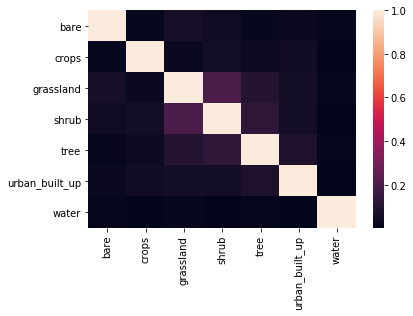

In [8]:
# sns.heatmap(znorm)

## Build Markov chain

Run necessary functions first

In [9]:
# optimise_node

def optimise_node(node, edges, edges_within, stepsize=5):

    # describe edges
    e = calc_energy(node, edges, edges_within)
    
    # Create empty list to keep track of energy
    eSim = []
    eSim.append(e)

    node = minimise_energy(node, edges, edges_within, eSim, stepsize)

    return node

In [10]:
def calc_energy(node, edges, edges_within):
    
#     param = 0.01
#     e_coocc = edges_within * node * param
    param = 0.01
    e_coocc = np.multiply(edges_within, node) * param
    
    
    # Old below
    edge1 = edges[0]
    edge2 = edges[1]
    
    e1 = (node - edge1)**2
    e2 = (node - edge2)**2
    
    if len(edges) == 3:
        edge3 = edges[2]
        e3 = (node - edge3)**2
        return e1 + e2 + e_coocc + e3
    
    return e1 + e2 + e_coocc

def calc_total_energy(nodes, edges, edges_within):
    
    list_of_energy = []

    for i in range(len(fractions_dict)):
        node = nodes[i]
        edge = edges[i]
        edge_within = edges_within[i]
        e = calc_energy(node, edge, edges_within)
        list_of_energy.append(e)
    
    return sum(list_of_energy)

def minimise_energy(node, edges, edges_within, eSim, stepsize):
    
    i = 0
    #print(i)
    
    if calc_energy(node + stepsize, edges, edges_within) < eSim[i] and (node + stepsize) <= 100:
        node = node + stepsize
        i += 1
        eSim.append(calc_energy(node, edges, edges_within))
        
        while calc_energy(node + stepsize, edges, edges_within) < eSim[i] and (node + stepsize) <= 100:
            node = node + stepsize
            i += 1
            eSim.append(calc_energy(node,edges, edges_within))
        
    elif calc_energy(node - stepsize, edges, edges_within) < eSim[i] and (node - stepsize) >= 0:
        node = node - stepsize
        i += 1
        eSim.append(calc_energy(node, edges, edges_within))
        
        while calc_energy(node - stepsize, edges, edges_within) < eSim[i] and (node - stepsize) >= 0:
            node = node - stepsize
            i += 1
            eSim.append(calc_energy(node, edges, edges_within))
    
    return node

In [11]:
def plot_simulations(eTotal, nodeSims):

    date_list = []
    for date in dates:
        date_list.append(date)
    
    # Plot energy over iterations
    xs = [x for x in range(len(eTotal))]
    plt.figure(figsize=(15,6), dpi= 100)
    plt.subplot(1, 3, 1)
    plt.plot(xs, eTotal)
    plt.ylabel('Energy', fontsize=14)
    plt.xlabel('Iterations', fontsize=14)

    # Plot nodes over iterations
    xs = [x for x in range(len(nodeSims[0]))]
    plt.subplot(1, 3, 2)
    for i in range(len(nodeSims)):
        plt.plot(xs, nodeSims[i])
    plt.ylabel('Fraction', fontsize=14)
    plt.xlabel('Iterations', fontsize=14)
    
    plt.legend(date_list, loc="upper left", bbox_to_anchor=(1, 0.5))

    xs = date_list
    yRF = rf_list
    yNode = optimised_nodes
    plt.subplot(1, 3, 3)
    plt.plot(xs, yRF)
    plt.plot(xs, yNode)
    plt.ylabel('Fractions', fontsize=14)
    plt.xlabel('Dates', fontsize=14)
    plt.legend(["Original","Smoothed"], loc="upper left", bbox_to_anchor=(1, 0.5))

    plt.tight_layout()
    
    fig = plt.figure()

    plt.show()

def plot_simulations(eTotal, nodeSims):

    date_list = []
    for date in dates:
        date_list.append(date)

    # Plot energy over iterations
    xs = [x for x in range(len(eTotal))]
    plt.figure(figsize=(15,18), dpi= 100) # change figsize to accommodate all subplots
    plt.subplot(3, 1, 1) # change to 3 rows and 1 column
    plt.plot(xs, eTotal)
    plt.ylabel('Energy', fontsize=14)
    plt.xlabel('Iterations', fontsize=14)

    # Plot nodes over iterations
    xs = [x for x in range(len(nodeSims[0]))]
    plt.subplot(3, 1, 2) # change to 3 rows and 1 column
    for i in range(len(nodeSims)):
        plt.plot(xs, nodeSims[i])
    plt.ylabel('Fraction', fontsize=14)
    plt.xlabel('Iterations', fontsize=14)

#     plt.legend(date_list, loc="upper left", bbox_to_anchor=(1, 0.5))

    xs = date_list
    yRF = rf_list
    yNode = optimised_nodes
    plt.subplot(3, 1, 3) # change to 3 rows and 1 column
    plt.plot(xs, yRF)
    plt.plot(xs, yNode)
    plt.ylabel('Fractions', fontsize=14)
    plt.ylim(0, 100)
    plt.xlabel('Dates', fontsize=14)
    plt.legend(["Original","Smoothed"], loc="upper left", bbox_to_anchor=(1, 0.5))

    plt.tight_layout()
    plt.show()


In [12]:
# How to change the paramters to get the optimal output:

# Coocc new 01:
# stepsize = 1
# param = 0.1

# Coocc new 001:
# stepsize = 1
# param = 0.01

# Coocc new 0001:
# stepsize = 1
# param = 0.001


Total run time: 0.813345193862915
Part run time 0.0030727386474609375


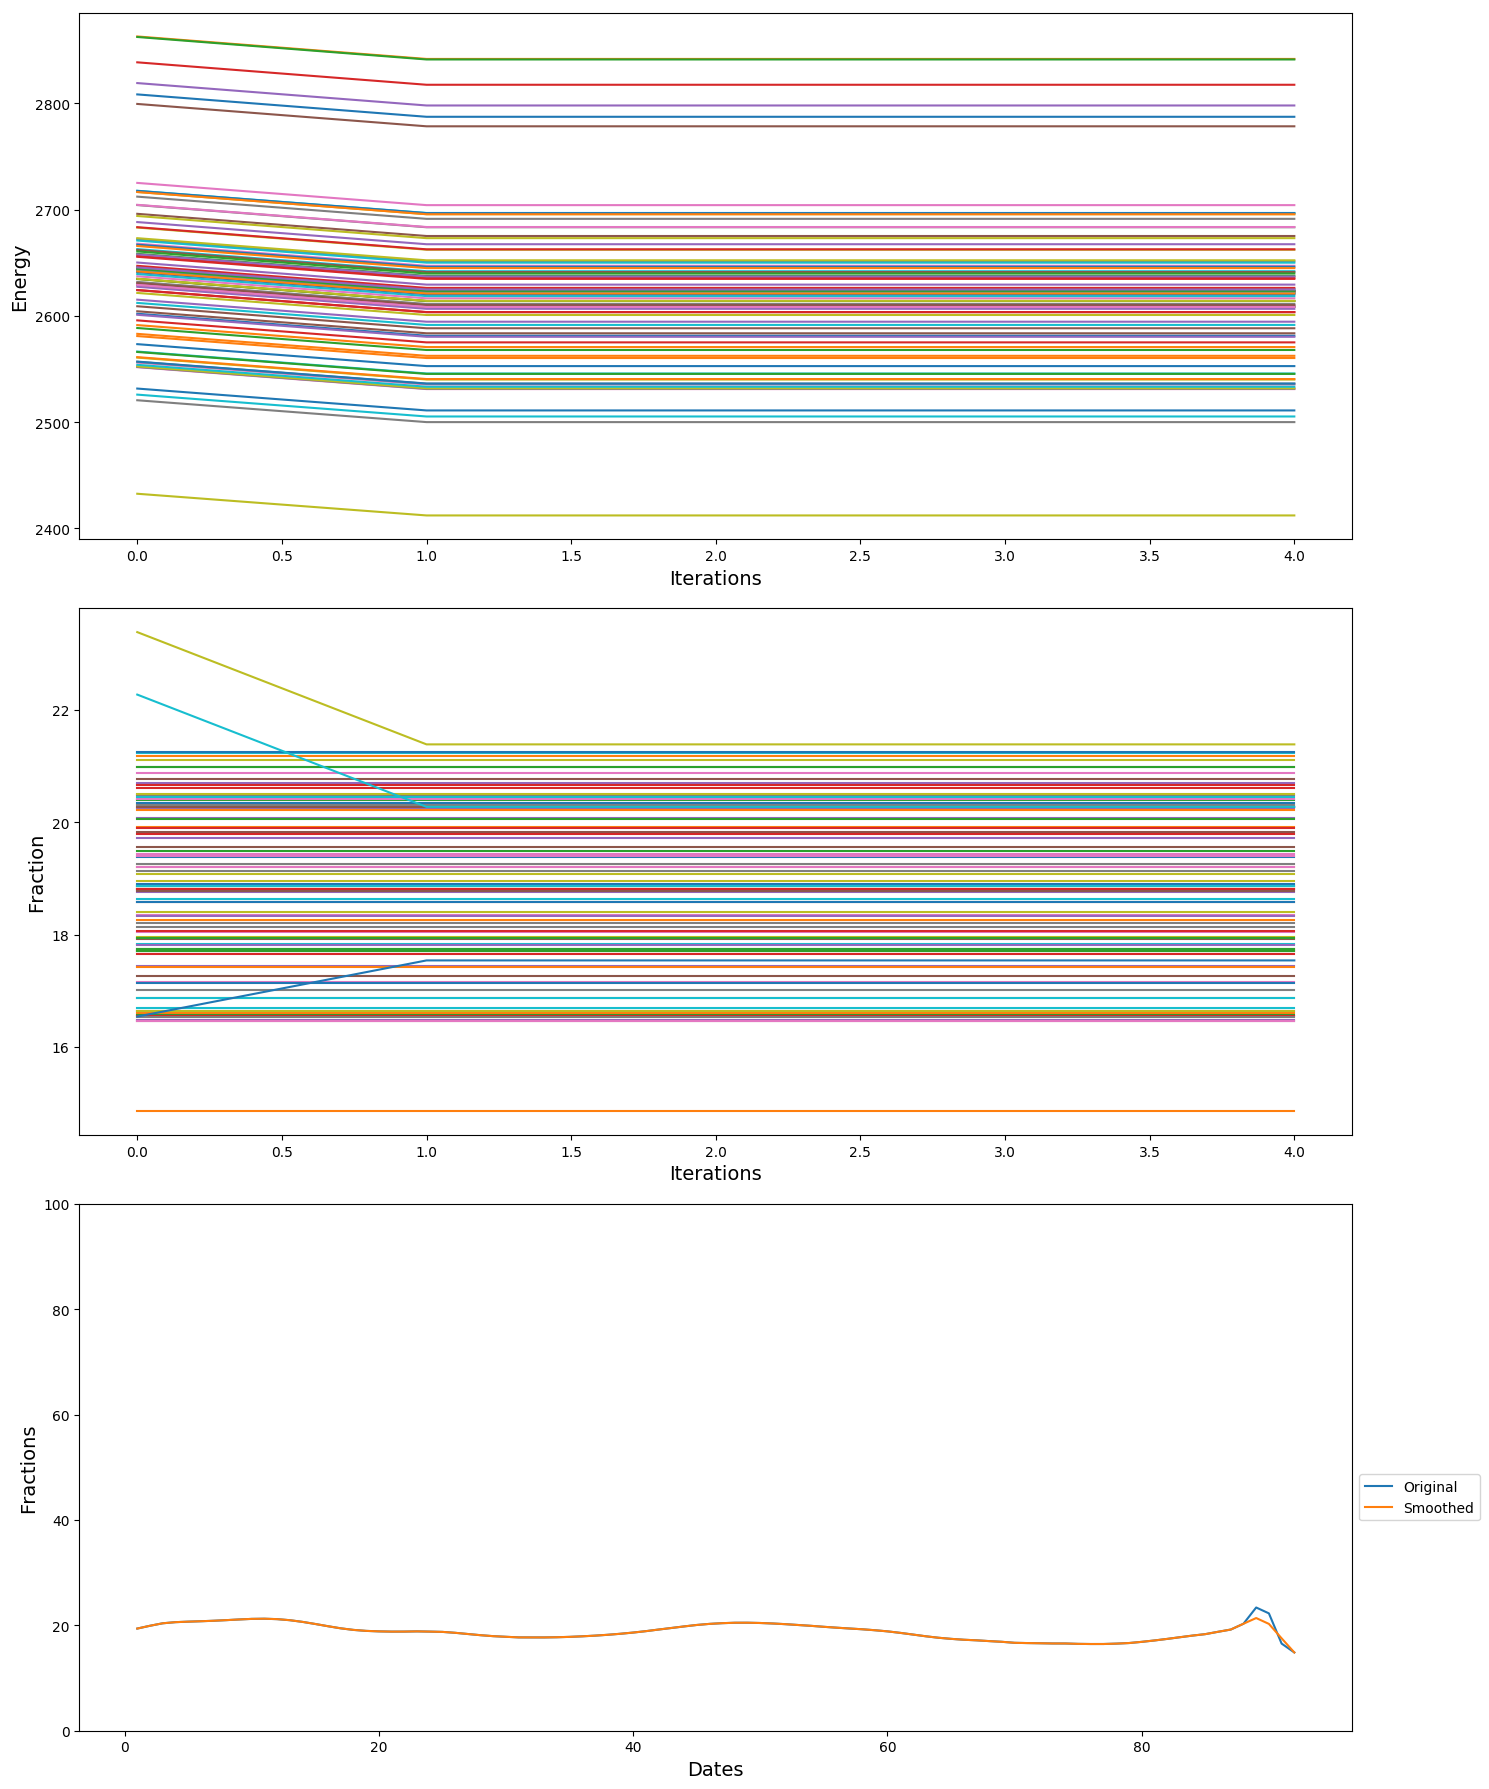

In [13]:
# Apply Markov chain model on ONE point only and check results.
t0 = time.time() # timer

i=1383

date_list = []
for date in dates:
    date_list.append(date)

listofdicts = []
listofdfs = []

for df_name in list(fractions_dict.keys()):
    df = fractions_dict[df_name].iloc[i]
    df_dict = dict(df)
    listofdfs.append(df)
    listofdicts.append(df_dict)

random.shuffle(classes)

for j in range(len(classes)):
    
    # Stepsize to find optimal fraction
    stepsize = 1
    plot = True
    
    dictofnodeSims = {}
    nodes_list = []
    rf_list = []
    within_list = []
    
    for i in range(len(listofdicts)):
        rf = listofdicts[i][classes[j]]
        rf_list.append(rf)
        
        node = rf
        node_list = []
        nodes_list.append(node)
        node_list.append(node)
        node_name = "nodeSim"+str(i)
        dictofnodeSims.update({node_name: node_list})
        
        # Within-year classes
        otherClasses = classes[:j] + classes[j+1:]
        other = {key: listofdicts[i][key] for key in otherClasses}
        
        # Within-year energy
        corr = znorm.loc[classes[j]][other.keys()]
        log = corr.apply(lambda x: -math.log(x))
        keys = list(log.index)
        within = sum([other[key] * log[key] for key in keys])
        within_list.append(within)
    
    edges_list = []
    for i in range(len(nodes_list)):
        if i == 0:
            edge = (rf_list[0], nodes_list[1])
        elif i == len(nodes_list) - 1:
            edge = (rf_list[-1], nodes_list[-2])
        else:
            edge = (rf_list[i], nodes_list[i-1], nodes_list[i+1])
        edges_list.append(edge)
    
    edges_tuple = tuple(edges_list)
    nodes_tuple = tuple(nodes_list)
    within_tuple = tuple(within_list)
     
    t1 = time.time()    
    
    eTotal = []
    eTotal.append(calc_total_energy(nodes = nodes_tuple,
                                    edges = edges_tuple,
                                    edges_within = within_tuple))

    e = calc_total_energy(nodes = nodes_tuple,
                          edges = edges_tuple,
                          edges_within = within_tuple)
  
    t2 = time.time()

    # Iterations over one chain
    for k in range(10):

        # Stop if total energy remains stable 3 iterations in a row
        if len(eTotal) >= 5 and np.all(eTotal[k] - eTotal[k-1]) == 0 and np.all(eTotal[k] - eTotal[k-2]) == 0: 
            break
        
        optimised_nodes = []
        
        for i in range(len(listofdicts)):
            
            node = optimise_node(nodes_tuple[i], edges=edges_tuple[i], edges_within=within_tuple[i], stepsize=stepsize)
            optimised_nodes.append(node)
            node_name = "nodeSim"+str(i)
            dictofnodeSims[node_name].append(node)
         
        # Calculate and store new total energy
        nodes = tuple(optimised_nodes)
        edges = edges_tuple
        e = calc_total_energy(nodes,edges,within_tuple)
        eTotal.append(e)

    for i in range(len(listofdicts)):
        listofdicts[i][classes[j]] = optimised_nodes[i]

t3 = time.time() # timer
print("\nTotal run time:", t3-t0)
print("Part run time", t2-t1)

# Plot
list_NodeSims = [dictofnodeSims[key] for key in dictofnodeSims]
if plot == True:
    plot_simulations(eTotal, list_NodeSims)


### Run Markov chain

In [14]:
# Keep track of time and progress
from tqdm import tqdm
t0 = time.time()

# Dates are index
date_list = []
for date in dates:
    date_list.append(date)    

# Loop over the amount of samples, which are the amount of unique IDs
num_samples = len(dense_pred.location_id.unique())

# Retain updated samples in list
all_smooth = []

# Loop over samples
with tqdm(total=num_samples, desc='Running Markov Chain...', position=0, leave=True) as pbar:
    
    for i in tqdm(range(num_samples), desc='Running Markov Chain...', position=0, leave=True):
        
        # Progressbar
        pbar.update()    
    
        listofdicts = []
        listofdfs = []

        for df_name in list(fractions_dict.keys()):
            df = fractions_dict[df_name].iloc[i]
            df_dict = dict(df)
            listofdfs.append(df)
            listofdicts.append(df_dict)

        random.shuffle(classes)

        for j in range(len(classes)):

            # Stepsize to find optimal fraction
            stepsize = 1
            plot = False

            dictofnodeSims = {}
            nodes_list = []
            rf_list = []
            within_list = []

            for a in range(len(listofdicts)):
                rf = listofdicts[a][classes[j]]
                rf_list.append(rf)

                node = rf
                node_list = []
                nodes_list.append(node)
                node_list.append(node)
                node_name = "nodeSim"+str(a)
                dictofnodeSims.update({node_name: node_list})

                # Within-year classes
                otherClasses = classes[:j] + classes[j+1:]
                other = {key: listofdicts[a][key] for key in otherClasses}

                # Within-year energy
                corr = znorm.loc[classes[j]][other.keys()]
                log = corr.apply(lambda x: -math.log(x))
                keys = list(log.index)
                within = sum([other[key] * log[key] for key in keys])
                within_list.append(within)

            edges_list = []
            for b in range(len(nodes_list)):
                if b == 0:
                    edge = (rf_list[0], nodes_list[1])
                elif b == len(nodes_list) - 1:
                    edge = (rf_list[-1], nodes_list[-2])
                else:
                    edge = (rf_list[b], nodes_list[b-1], nodes_list[b+1])
                edges_list.append(edge)

            edges_tuple = tuple(edges_list)
            nodes_tuple = tuple(nodes_list)
            within_tuple = tuple(within_list)

            t1 = time.time()    

            eTotal = []
            eTotal.append(calc_total_energy(nodes = nodes_tuple,
                                            edges = edges_tuple,
                                            edges_within = within_tuple))

            e = calc_total_energy(nodes = nodes_tuple,
                                  edges = edges_tuple,
                                  edges_within = within_tuple)

            t2 = time.time()

            # Iterations over one chain
            for k in range(10):

                # Stop if total energy remains stable 3 iterations in a row
                if len(eTotal) >= 5 and np.all(eTotal[k] - eTotal[k-1]) == 0 and np.all(eTotal[k] - eTotal[k-2]) == 0: 
                    break

                optimised_nodes = []

                for c in range(len(listofdicts)):

                    node = optimise_node(nodes_tuple[c], edges=edges_tuple[c], edges_within=within_tuple[c], stepsize=stepsize)
                    optimised_nodes.append(node)
                    node_name = "nodeSim"+str(c)
                    dictofnodeSims[node_name].append(node)

                # Calculate and store new total energy
                nodes = tuple(optimised_nodes)
                edges = edges_tuple
                e = calc_total_energy(nodes,edges,within_tuple)
                eTotal.append(e)
            
            # Retain smoothed predictions
            for d in range(len(listofdicts)):
                listofdicts[d][classes[j]] = optimised_nodes[d]

        # Append updated sample        
        all_smooth.append(listofdicts)
      
t1 = time.time()
print("Total run time:", t1-t0)
print("Done")

Running Markov Chain...: 100%|██████████| 30674/30674 [7:10:28<00:00,  1.19it/s]

Total run time: 25828.752074480057
Done


#### Create data frame

In [15]:
# Lists to df                
for i in range(len(all_smooth)):
    
    # Progress
    print("\rCreating DF out of predictions. At sample: {}/{}".format(i, len(all_smooth)), end='\r')
    
    if i == 0:
        smooth_df = pd.DataFrame(all_smooth[i], columns=list(df2015.columns), index=date_list)
    else:
        new_row = pd.DataFrame(all_smooth[i], columns=list(df2015.columns), index=date_list)
        smooth_df = smooth_df.append(new_row)

# Normalise predictions so that they add up to 100
smooth_df[smooth_df < 0] = 0
smooth_df[smooth_df > 100] = 100
smooth_df = smooth_df.div(smooth_df.sum(axis=1), axis=0) * 100

# Replace NaN values with 0 (NaN resulting from normalisation)
smooth_df = smooth_df.replace(np.nan, 0)

print("\n", "Done")

Creating DF out of predictions. At sample: 30673/30674
 Done


In [ ]:
smooth_df.head(12)

### Check results

In [17]:
# Join back IDs
id_cols = dense_pred[ids]

# convert dataframes to numpy arrays
smooth_np = smooth_df.to_numpy()
id_np = id_cols.to_numpy()

# join numpy arrays along columns axis
result_np = np.concatenate((id_np, smooth_np), axis=1)

# convert result back to dataframe
markov = pd.DataFrame(result_np, columns=id_cols.columns.tolist() + smooth_df.columns.tolist())
# markov['date'] = dense_pred['date'].str.replace("-", "").astype(int)

In [ ]:
markov.head(12)

In [19]:
import random

locations = dense_pred.location_id.unique()
random_location = random.choice(locations)

old_df = dense_pred.loc[dense_pred['location_id'] == random_location]
new_df = markov.loc[markov['location_id'] == random_location]

In [ ]:
old_df.head(12)

In [ ]:
new_df.head(12)

#### Make also aggregated data frame for validation

In [ ]:
years = np.array(['2015', '2016', '2017', '2018'])

def segment_average(group):
    y = group['y'].iloc[0]
    if y > 0:
        segment_rows = [(10, 16), (33, 39), (56, 62), (79, 85)]
    else:
        segment_rows = [(0, 6), (23, 29), (46, 52), (69, 75)]
    averages = []
    for start, end in segment_rows:
        segment_data = group.iloc[start:end, :]
        segment_avg = segment_data.mean()
        averages.append(segment_avg)
    return pd.concat(averages, axis=1).T

# Group by location_id and apply the segment_average function to each group
dense_to_agg_df = markov.groupby('location_id').apply(segment_average)

# Reset the index and extract the years
dense_to_agg_df = dense_to_agg_df.reset_index(drop=True)

# Date column can be converted back to string format (shows +- growing season date) and years column can be added
repeated_years = np.tile(years, len(dense_to_agg_df))
dense_to_agg_df['reference_year'] = repeated_years.flatten()[:len(dense_to_agg_df)]
dense_to_agg_df = dense_to_agg_df.drop(['date'], axis=1)

# Check if done properly
dense_to_agg_df.head(12)


### Write to file

In [23]:
markov.to_csv('Output/Markov/Dense_LSTMMarkov.csv')
dense_to_agg_df.to_csv('Output/Markov/DenseAgg_LSTMMarkov.csv')